

Data source: [Presidenza del Consiglio dei Ministri - Dipartimento della Protezione Civile](https://github.com/pcm-dpc)

ISTAT dataset download (population, Jan 2020): [Popolazione residente comunale per sesso anno di nascita e stato civile](http://dati.istat.it/Index.aspx?DataSetCode=DCIS_POPRES1)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Create a dictionary with population data

In [2]:
!cp ../DCIS_POPRES1_04122020161839934.csv dataset_ISTAT/

In [3]:
istat_dataset = './dataset_ISTAT/DCIS_POPRES1_04122020161839934.csv'

# create a dataframe
prov = pd.read_csv(istat_dataset)

# isolate rows with totals only (no splitting for sex or age)
only_totals = (prov.Sesso=='totale')&(prov.ETA1=='TOTAL')

# "ITTER107" column is filled with:
#  2 letters (Italy data = "IT")
#  3 letters (macro areas: north, center, ...) 
#  3 letters + 1 digit for regions
#  3 lettere + 2 digits for provinces
#     check with prov[solo_totali].ITTER107.apply(lambda x:len(x)).value_counts()
#  --> filter to isolate prov data (counting number of letter in the string):
only_prov = prov.ITTER107.apply(lambda x : len(x)==5)

# reduced dataframe (just province name and value)
reduced = prov[only_prov & only_totals][['Territorio', 'Value']]

# END: create a dictionary with population 
#   (fix some names for compatibility with Protezione Civile's database)
population = {row['Territorio'].replace("Valle d'Aosta / Vallée d'Aoste", 'Aosta').replace('Bolzano / Bozen', 'Bolzano').replace('Massa-Carrara', 'Massa Carrara'):row['Value'] for i, row in reduced.iterrows()}

Covid19 data, 7-days rolling average

In [4]:
# create the dataframe,
# exclude long province names (they are not provinces but other temporary data),
# skim and set a datetime index

source_italy_prov = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-province/dpc-covid19-ita-province.csv'
df = pd.read_csv(source_italy_prov)
df

,data,stato,codice_regione,denominazione_regione,codice_provincia,denominazione_provincia,sigla_provincia,lat,long,totale_casi,note,codice_nuts_1,codice_nuts_2,codice_nuts_3
0,2020-02-24T18:00:00,ITA,13,Abruzzo,66,L'Aquila,AQ,42.351222,13.398438,0,NaN,NaN,NaN,NaN
1,2020-02-24T18:00:00,ITA,13,Abruzzo,67,Teramo,TE,42.658918,13.704400,0,NaN,NaN,NaN,NaN
2,2020-02-24T18:00:00,ITA,13,Abruzzo,68,Pescara,PE,42.464584,14.213648,0,NaN,NaN,NaN,NaN
3,2020-02-24T18:00:00,ITA,13,Abruzzo,69,Chieti,CH,42.351032,14.167546,0,NaN,NaN,NaN,NaN
4,2020-02-24T18:00:00,ITA,13,Abruzzo,979,In fase di definizione/aggiornamento,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52861,2021-03-01T17:00:00,ITA,5,Veneto,27,Venezia,VE,45.434905,12.338452,53882,NaN,ITH,ITH3,ITH35
52862,2021-03-01T17:00:00,ITA,5,Veneto,28,Padova,PD,45.406930,11.876087,62567,NaN,ITH,ITH3,ITH36
52863,2021-03-01T17:00:00,ITA,5,Veneto,29,Rovigo,RO,45.071073,11.790070,10666,NaN,ITH,ITH3,ITH37
52864,2021-03-01T17:00:00,ITA,5,Veneto,899,Fuori Regione / Provincia Autonoma,NaN,NaN,NaN,4467,NaN,ITH,ITH3,NaN


In [5]:
df = df[df.denominazione_provincia.apply(lambda x:len(x)<30)]
df = df[['data', 'denominazione_provincia','denominazione_regione','totale_casi']].set_index(pd.to_datetime(df.data)).drop('data',axis=1)

# create another dataframe isolating each province and computing a rolling average on 7 days
lista_prov=[]
for p in df.denominazione_provincia.unique():
    serie = df[df.denominazione_provincia==p].totale_casi.diff().rolling(7, center=True).sum()/population[p]*100000
    lista_prov.append(serie.rename(p))

allprov = pd.concat(lista_prov, axis=1, join='outer')

Plot data for Emilia Romagna

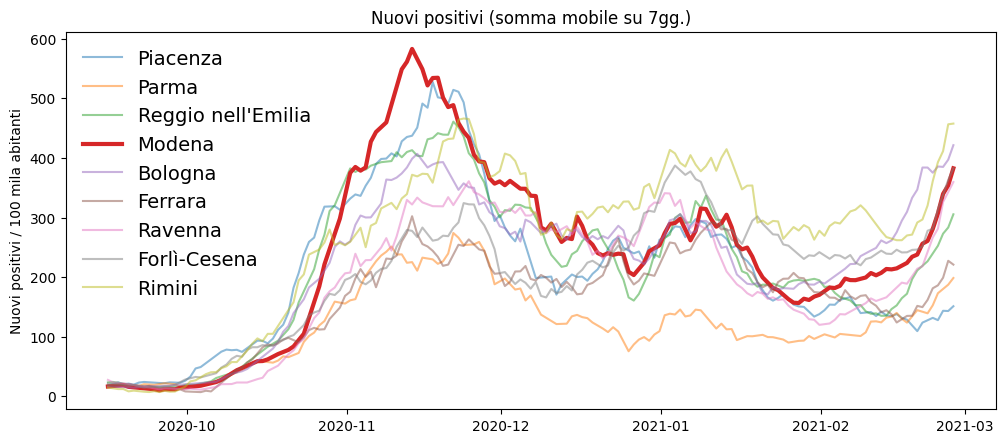

In [6]:
# plt.style.use('Solarize_Light2')
plt.style.use('fast')
plt.subplots(figsize=(12,5),dpi=100, edgecolor='k')
these = list(df[df.denominazione_regione=='Emilia-Romagna'].denominazione_provincia.unique())
# queste += list(df[df.denominazione_regione=='Lombardia'].denominazione_provincia.unique())
# queste += list(df[df.denominazione_regione=='Veneto'].denominazione_provincia.unique())
# queste += list(df[df.denominazione_regione=='Piemonte'].denominazione_provincia.unique())
# queste += list(df[df.denominazione_regione=='Toscana'].denominazione_provincia.unique())

for p in these:
    
    plt.plot(allprov[p]['2020-09-15':], label=p, linewidth=1.5 if p!='Modena' else 3, alpha=0.5 if p!='Modena' else 1)
    
plt.title('Nuovi positivi (somma mobile su 7gg.)', fontsize=12)
plt.ylabel('Nuovi positivi / 100 mila abitanti')
    
plt.legend(frameon=False, fontsize=14, loc='upper left', ncol=1)
plt.gcf().savefig('emilia_romagna.png')
plt.show()


Plot NORD

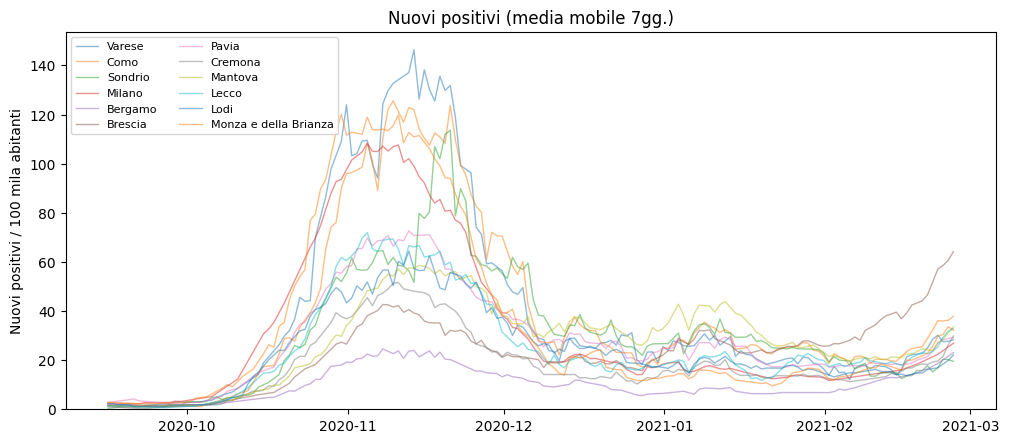

In [16]:
# plt.style.use('Solarize_Light2')
plt.style.use('fast')
plt.subplots(figsize=(12,5),dpi=100)
these = list(df[df.denominazione_regione=='Lombardia'].denominazione_provincia.unique())
#these += list(df[df.denominazione_regione=='Emilia-Romagna'].denominazione_provincia.unique())
# these += list(df[df.denominazione_regione=='Veneto'].denominazione_provincia.unique())
#these += list(df[df.denominazione_regione=='Piemonte'].denominazione_provincia.unique())
# these += list(df[df.denominazione_regione=='Toscana'].denominazione_provincia.unique())

for p in these:
    settings = {
        'linewidth' :1 if p!='Modena' else 3,
        'alpha' : 0.5 if p!='Modena' else 1,
        'label' : p
    }
    plt.plot(allprov[p]['2020-09-15':],**settings)
    
plt.title('Nuovi positivi (media mobile 7gg.)', fontsize=12)
plt.ylabel('Nuovi positivi / 100 mila abitanti')
plt.gca().set_ybound(lower=0)
plt.legend(fontsize=8, loc='upper left', ncol=2)
plt.gcf().savefig('varie_norditalia.png')
plt.show()

Create a series to inspect max and mins

In [17]:
lista = lista_prov
lista = [s['2021-02':] for s in lista_prov]
pd.concat(lista, keys=[s.name for s in lista]).sort_values(ascending=False).head(30)

         data               
Bolzano  2021-02-07 17:00:00    120.041025
         2021-02-08 17:00:00    118.242155
         2021-02-09 17:00:00    116.980261
         2021-02-06 17:00:00    116.389587
         2021-02-04 17:00:00    115.825762
         2021-02-03 17:00:00    115.745216
         2021-02-05 17:00:00    114.187985
         2021-02-10 17:00:00    111.852138
         2021-02-02 17:00:00    111.395708
         2021-02-11 17:00:00    109.838478
         2021-02-01 17:00:00    108.791374
         2021-02-12 17:00:00    108.683979
         2021-02-13 17:00:00    104.468716
         2021-02-14 17:00:00     95.366970
         2021-02-15 17:00:00     89.943510
         2021-02-16 17:00:00     86.829048
         2021-02-17 17:00:00     83.231308
         2021-02-18 17:00:00     81.029706
         2021-02-19 17:00:00     80.251090
         2021-02-20 17:00:00     75.149816
         2021-02-21 17:00:00     72.599180
Pescara  2021-02-16 17:00:00     71.635229
         2021-02-18 17:00

In [18]:
population['Modena']

707292